# Exercise 2.3

In [1]:
# Import some necessary libraries
import numpy as np
from scipy.integrate import odeint, solve_ivp

# Import plotting tools.
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

This exercise is modified using the fKdVB equation in place of the KdV equation, the parameters are inspired to the pdf file (with title [Solution of the Forced Korteweg-de VriesBurgers Nonlinear Evolution Equation](https://core.ac.uk/download/pdf/12005598.pdf)) provided in this directory. The **fKdVB equation** is a nonlinear evolution equation that combines several effects such as forcing, $f(x)$, nonlinearity, $\varepsilon UU_x$, dissipation, $\nu U_{xx}$ and dispersion, $\mu U_{xxx}$:

$$u_t + \mu \cdot u_{xxx} - \nu \cdot U_{xx} + \varepsilon \cdot u_xu = 0$$

in this exercise, we will always assume $f(x) = 0$. The parameters which play a role in the dynamic described from the fKdVB equation are:

- ```mu``` ,  ```nu``` , ```epsilon``` : parameters which determin the importance of the different terms of the fKdVB equation.
- ```L``` : domain space length.
- ```N``` : number of point where the solution of the PDE is evaluated.
- ```dx``` : infinitesimal space-element.
- ```x``` and ```t``` : vectors defining the space and the time domains.
- ```k``` : wave numbers defined on the basis of the space domain. 

And the starting conditions:

- ```u0``` : vector containing the space starting conditions, that we will define vis $sech(x)^2$.


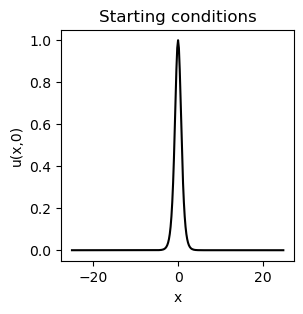

In [2]:
# Plot function for starting conditions.
def plot1( x , u0 ):
    fig = plt.figure( figsize = ( 3 , 3 ) )
    _ = plt.plot( x , u0 , color = "black")
    plt.xlabel("x")
    plt.ylabel("u(x,0)")
    _ = plt.title("Starting conditions")

# Define constants.
mu = 1
nu = 1e-3
epsilon = 6
L = 50                   
N = 256                       
dx = L / N                   
x = np.arange( -L/2 , L/2 , dx )   
t = np.arange(0, 1, 0.01)

# Define discrete wavenumbers.
kappa = ( 2 * np.pi / L ) * np.arange( - N / 2 , N / 2 )  
kappa = np.fft.fftshift( kappa )

# Define the starting conditions.
u0 = np.power( ( 1 / np.cosh(x) ) , 2 )

# Plot the starting conditions.
plot1( x , u0 )

In the following block of code, the Right-Hand-Side (RHS) of the ODE system is defined. As explained at page 75 of the book *Data-Driven Science and Engineering*, when mixed non-linear terms are present into the governing equation, it is necessary to map each term in and out the Fourier space at each time-step to recover the correct dynamic of the system.

In [3]:
# Define RHS of ODE system.
def RHSfKdVB( u , t, kappa , mu , nu , epsilon ):
    
    # map into the Fourier space.
    uhat = np.fft.fft(u)  
    uhat_x = ( 1j ) * kappa * uhat 
    uhat_xx = np.power( ( 1j ) * kappa , 2 ) * uhat
    uhat_xxx = np.power( ( 1j ) * kappa , 3 ) * uhat
    
    # map outside the Fourier space.
    u_x = np.fft.ifft( uhat_x )
    u_xx = np.fft.ifft( uhat_xx )
    u_xxx = np.fft.ifft( uhat_xxx )
    du_dt = - mu * u_xxx + nu * u_xx - epsilon * u * u_x  
    
    return du_dt.real

The fKdVB RHS, together with the starting conditions, the time-grid and the equations parameters are given to the solver ```odeint``` (from ```scipy```), which integrates $u_t$ in time. The result id then plotted:
- The left plot shows the temporal evolution of the fKdVB equation.
- The right plot will show the projections of the $u(x, \hat t)$ profiles for different time instants ( $\hat t$ ).

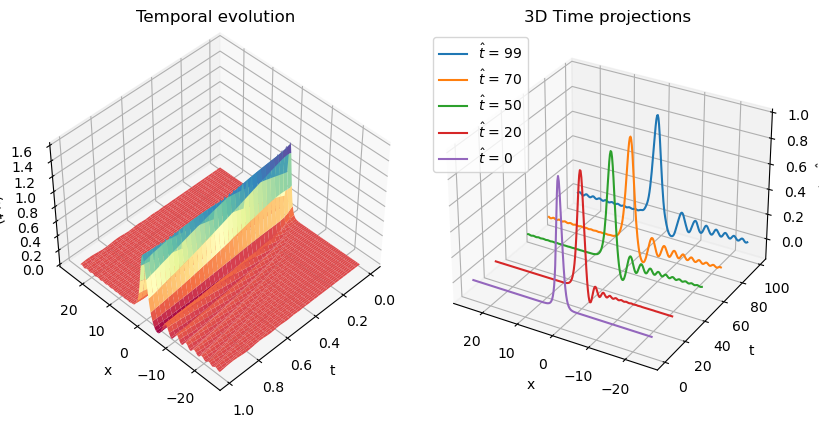

In [4]:
# Plot functions.
def plot2( x , t , sol ):
    
    plt.close()
    fig = plt.figure( figsize = ( 8 , 4 ) )
    ax1 = fig.add_subplot( 121 , projection = '3d' )
    ax2 = fig.add_subplot( 122 , projection = '3d' )

    X , T = np.meshgrid( x , t )
    surf = ax1.plot_surface( T , X , sol.real , cmap = 'Spectral' , rstride = 3, cstride = 3, antialiased = True )
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_zlabel('u(x,t)')
    ax1.set_title("Temporal evolution")
    ax1.invert_yaxis()
    ax1.set_zlim( 0 , 1.6 )
    ax1.view_init( 45 , 45 )
    
    for i in [ 99 , 70 , 50 , 20 , 0 ]:
        tt = i * np.ones( sol.real.shape[1] )
        ax2.plot( x , tt , sol.real[ i , : ] , label = "$\hat{t}$ = " + str(i) )
    ax2.set_xlabel("x")
    ax2.set_ylabel("t")
    ax2.set_zlabel("u(x,t)")
    ax2.set_zlabel("$u(x,\hat{t})$")
    ax2.set_title("3D Time projections")
    ax2.legend( loc = "upper left" )
    ax2.invert_xaxis()
    
    plt.tight_layout()
    plt.show()

# Integrate the PDE 
sol = odeint( RHSfKdVB , u0 , t , args = ( kappa , mu , nu , epsilon ) ) 
# Plot the result.
plot2( x , t , sol )